# NasNet Dog Breeds

### Easy steps to train a world-class image classifier:
1. freeze all but last layer
1. turn on caching of frozen layers
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting
1. Check validation results, compare to other models
1. Select best model, retrain entirely on full data set

### Setup

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.conv_learner import *
from fastai.plots import *
assert torch.cuda.is_available()
assert torch.backends.cudnn.enabled

import pathlib
import multiprocessing as mp
from sklearn.metrics import confusion_matrix

### Define utility functions

In [2]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = ["Predicted: %s (%.4f)\nTruth: %s" % (data.classes[preds[x]], np.max(probs[x,:]), data.classes[data.val_y[x]]) for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(28,10))      

def sort_by_correct(is_correct, n=4):   
    bools = (preds == data.val_y)==is_correct 
    pairs = list(zip(bools, np.max(probs,axis=1))) 
    p = np.array([i[1] if i[0]==True else 0 for i in pairs])         
    tops = p.argsort()[::-1][:n]
    return tops

def most_uncertain(n=4): return np.max(probs,axis=1).argsort()[:n]

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def most_by_mask(mask):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(probs[idxs])[:4]]

def most_by_correct(is_correct): 
    return most_by_mask((preds == data.val_y)==is_correct)

### Get data

In [3]:
!kaggle competitions list -s breeds*

ref                       deadline             category    reward  teamCount  userHasEntered  
------------------------  -------------------  ----------  ------  ---------  --------------  
dog-breed-identification  2018-02-26 23:59:00  Playground   Kudos       1286            True  


In [4]:
PATH = '/home/paperspace/data/kaggle/dog-breed-identification/'

In [5]:
# download
!rm -rf {PATH}
!mkdir -p {PATH}
!kaggle competitions download -c dog-breed-identification -p {PATH}
!ls {PATH}

  0%|                                                | 0.00/214k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 214k/214k [00:00<00:00, 7.79MB/s]
  0%|                                                | 0.00/318k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 318k/318k [00:00<00:00, 11.3MB/s]
 98%|███████████████████████████████████████ | 338M/346M [00:12<00:00, 57.5MB/s]
100%|████████████████████████████████████████| 346M/346M [00:12<00:00, 29.6MB/s]
 98%|███████████████████████████████████████▏| 338M/345M [00:06<00:00, 62.8MB/s]
100%|████████████████████████████████████████| 345M/345M [00:06<00:00, 57.0MB/s]
labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


In [6]:
# unzip
!unzip -q '{PATH}/*.zip' -d {PATH}
!ls {PATH}


4 archives were successfully processed.
labels.csv	sample_submission.csv	   test      train
labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


### Inspect, load and augment data

In [5]:
TRAIN_PATH = os.path.join(PATH,'train')
os.listdir(TRAIN_PATH)[:3]
full_train = glob(os.path.join(TRAIN_PATH, '*.jpg'))

['d8275152fe9027835bec0c405d131a2b.jpg',
 '44b4684cac2f73ba81b6ed86e45244ad.jpg',
 'bc218eeb424cf93092b0a0b23035bbad.jpg']

#### Take a look

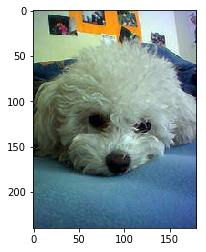

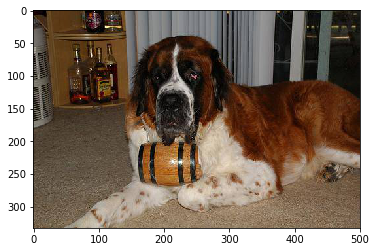

In [6]:
for i in range(2):
    img = plt.imread(full_train[i]);
    plt.figure();
    plt.imshow(img);
plt.show();

In [7]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
assert len(full_train) == n
val_idxs = get_cv_idxs(n)

def get_data(sz,bs=64):
    stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    tfms = tfms_from_stats(stats, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', bs=bs)

In [8]:
data = get_data(224,64)

# stats
len(data.trn_ds), len(data.val_ds), len(data.test_ds)
len(data.classes)
data.classes[:5]
data.val_y[:5]

# class numbers
labels_df = pd.read_csv(label_csv)
labels_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

(8178, 2044, 10357)

120

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

array([19, 15,  7, 99, 73])

id
breed                              
scottish_deerhound              126
maltese_dog                     117
afghan_hound                    116
entlebucher                     115
bernese_mountain_dog            114
shih-tzu                        112
great_pyrenees                  111
pomeranian                      111
basenji                         110
samoyed                         109
airedale                        107
tibetan_terrier                 107
leonberg                        106
cairn                           106
beagle                          105
japanese_spaniel                105
australian_terrier              102
blenheim_spaniel                102
miniature_pinscher              102
irish_wolfhound                 101
lakeland_terrier                 99
saluki                           99
papillon                         96
whippet                          95
siberian_husky                   95
norwegian_elkhound               95
pug                              94
chow                             93
italian_greyhound                92
pembroke                         92
...                             ...
german_short-haired_pointer      75
boxer                            75
bull_mastiff                     75
borzoi                           75
pekinese                         75
cocker_spaniel                   74
american_staffordshire_terrier   74
doberman                         74
brittany_spaniel                 73
malinois                         73
standard_schnauzer               72
flat-coated_retriever            72
redbone                          72
border_collie                    72
curly-coated_retriever           72
kuvasz                           71
chihuahua                        71
soft-coated_wheaten_terrier      71
french_bulldog                   70
vizsla                           70
tibetan_mastiff                  69
german_shepherd                  69
giant_schnauzer                  69
walker_hound                     69
otterhound                       69
golden_retriever                 67
brabancon_griffon                67
komondor                         67
briard                           66
eskimo_dog                       66

[120 rows x 1 columns]

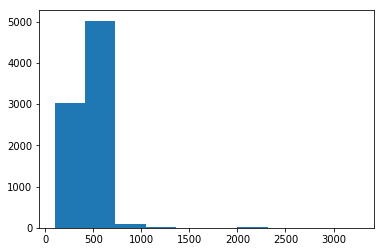

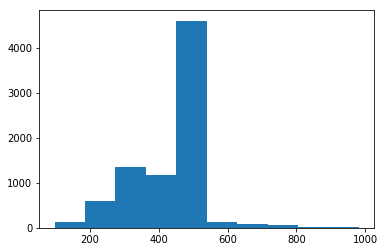

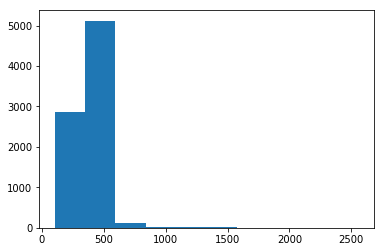

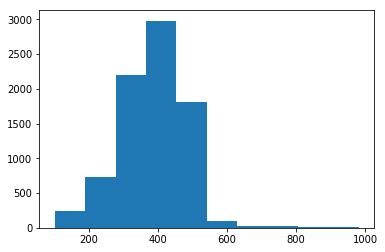

In [9]:
# check image set dimensions
size_d = {k:PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz,col_sz = list(zip(*size_d.values()))
row_sz=np.array(row_sz); col_sz=np.array(col_sz)

plt.hist(row_sz);
plt.show();
plt.hist(row_sz[row_sz<1000]);
plt.show();

plt.hist(col_sz);
plt.show();
plt.hist(col_sz[col_sz<1000]);
plt.show();

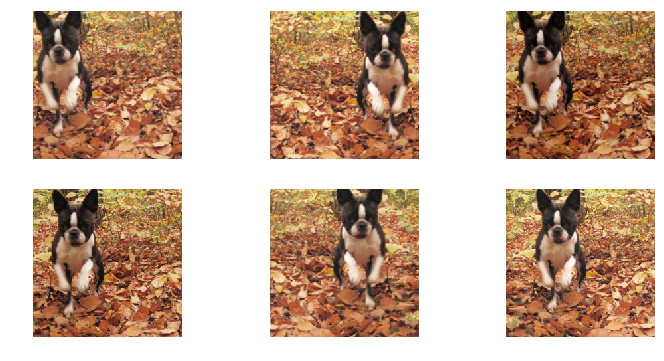

In [10]:
# show data augmentations examples used to reduce overfitting/improve generalization
def get_augs(data, ix=0):
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[ix]

ims = np.stack([get_augs(data, ix=0) for i in range(6)])
plots(ims, rows=2)

## Begin modeling

In [13]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [11]:
def nasnet(pre): return nasnetalarge(pretrained = 'imagenet' if pre else None)
model_features[nasnet]=4032*2
arch=nasnet

### Choose a learning rate
Gradually increase learning rate from very small value until loss stops decreasing, in order to find learning rate that improves loss most quickly (lowest slope, and round up, since this will be the MAX rate used after adding additional learning rates later)

In [15]:
# Precompute activation functions (also freezes all but last layer)
learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[], ps=0.5)

100%|██████████| 162/162 [02:09<00:00,  1.25it/s]


In [16]:
lrf=learn.lr_find()

 88%|████████▊ | 113/128 [00:02<00:00, 47.88it/s, loss=6.03]


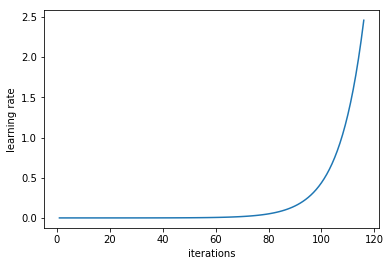

In [17]:
# look at the learning rate schedule
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

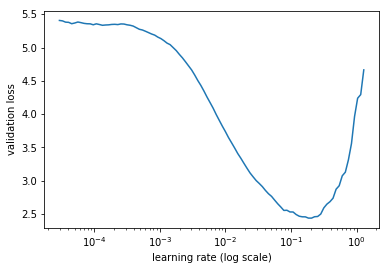

In [18]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we train the model, so you may want to re-run this function from time to time.

### Train final layer with caching of frozen layers for speed

In [19]:
%time learn.fit(2e-3, n_cycle=3, cycle_len=1, cycle_mult=1) # looks like this is showing val_loss == log_loss

epoch      trn_loss   val_loss   accuracy                    
    0      0.87128    0.41939    0.892857  
    1      0.440616   0.400418   0.892368                    
    2      0.370145   0.362402   0.895303                    

CPU times: user 7.13 s, sys: 5.98 s, total: 13.1 s
Wall time: 9.43 s


[array([0.3624]), 0.8953033264602467]

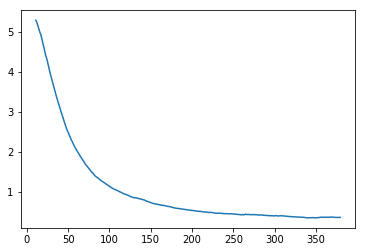

In [20]:
learn.sched.plot_loss()

In [21]:
learn.save('nas_pre')
learn.load('nas_pre')

#### check current validation results

In [22]:
# predict on validation set (in log scale)
log_preds = learn.predict()
log_preds.shape
preds = np.argmax(log_preds, axis=1)  # from log probabilities to integer class mappings
probs = np.exp(log_preds)        # probability of each breed
preds[:10]

from sklearn.metrics import log_loss
log_loss(data.val_y, probs)

(2044, 120)

array([19, 15,  7, 99, 73, 79, 21, 38, 10, 26])

0.3760055132692547

Correctly classified


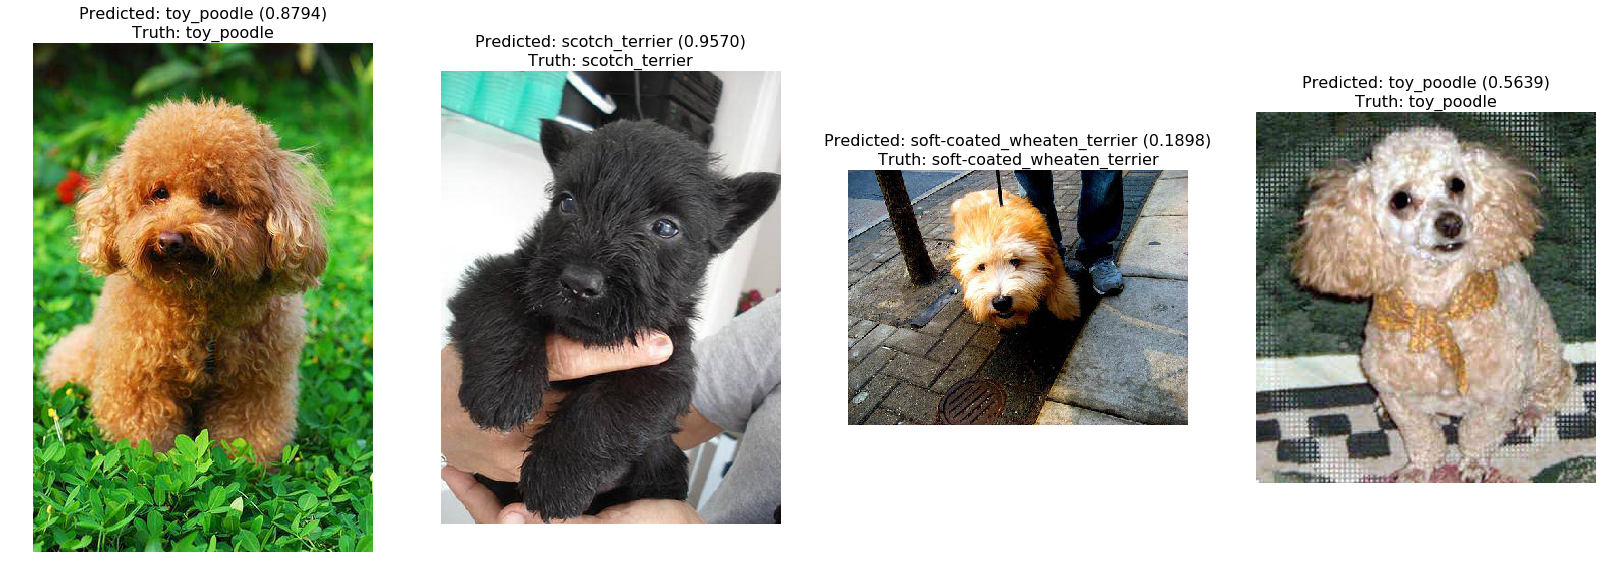

In [23]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


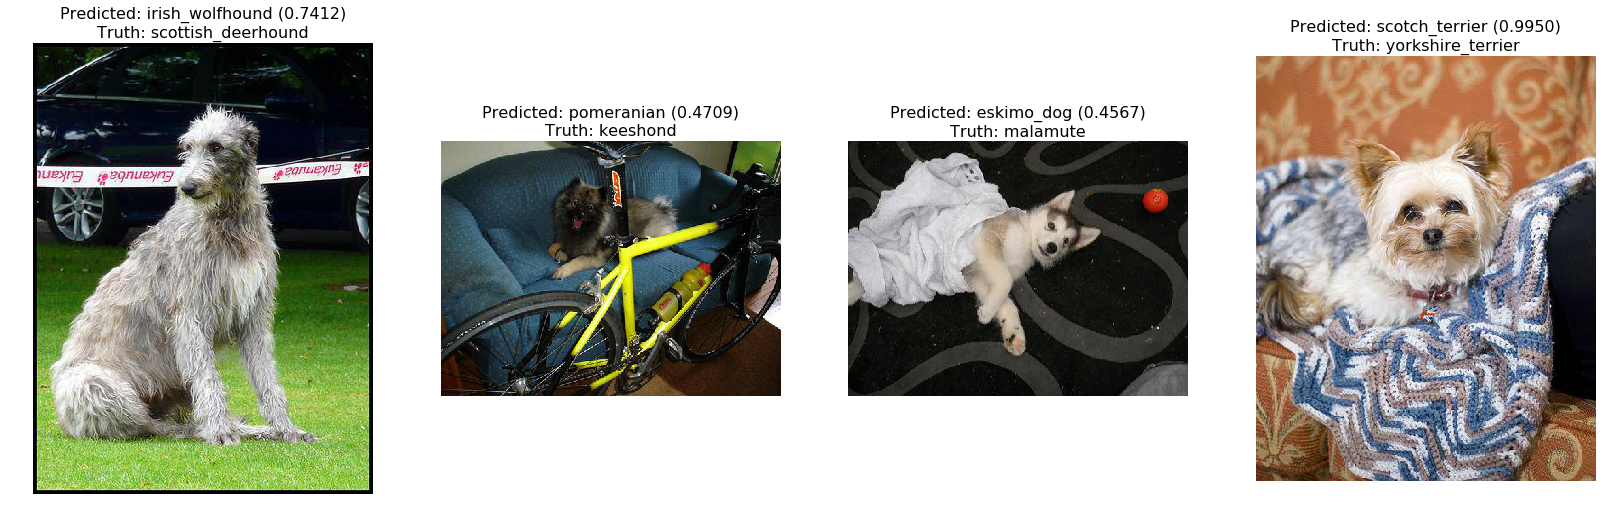

In [24]:
# 2. A few incorrect labels at random
# Remember, square center is cropped, so vital information existing on edges could cause misclassification!s
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correctly classified


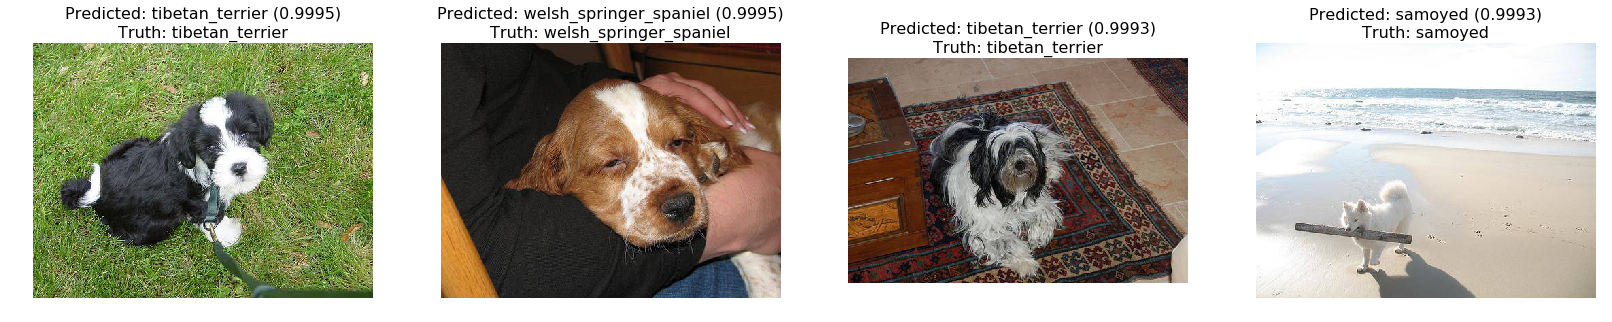

In [25]:
# 3. A few of the most correct labels
plot_val_with_title(sort_by_correct(True), "Most correctly classified")

Most incorrectly classified


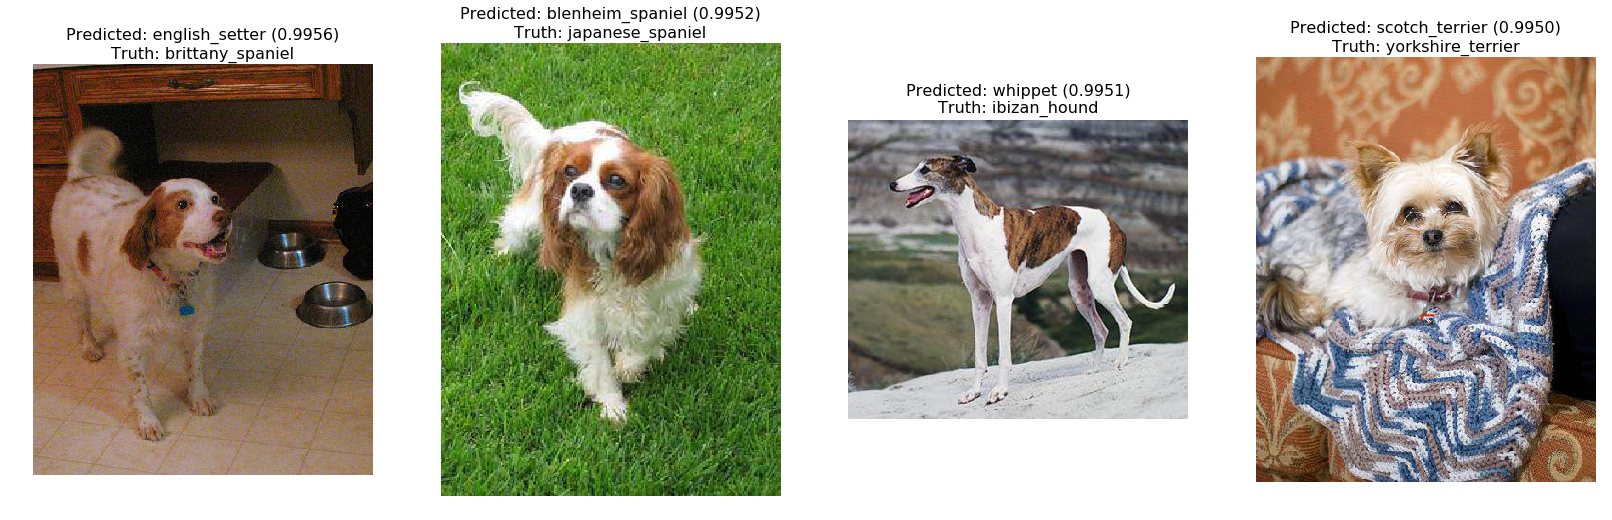

In [26]:
plot_val_with_title(sort_by_correct(False), "Most incorrectly classified")

Most uncertain predictions


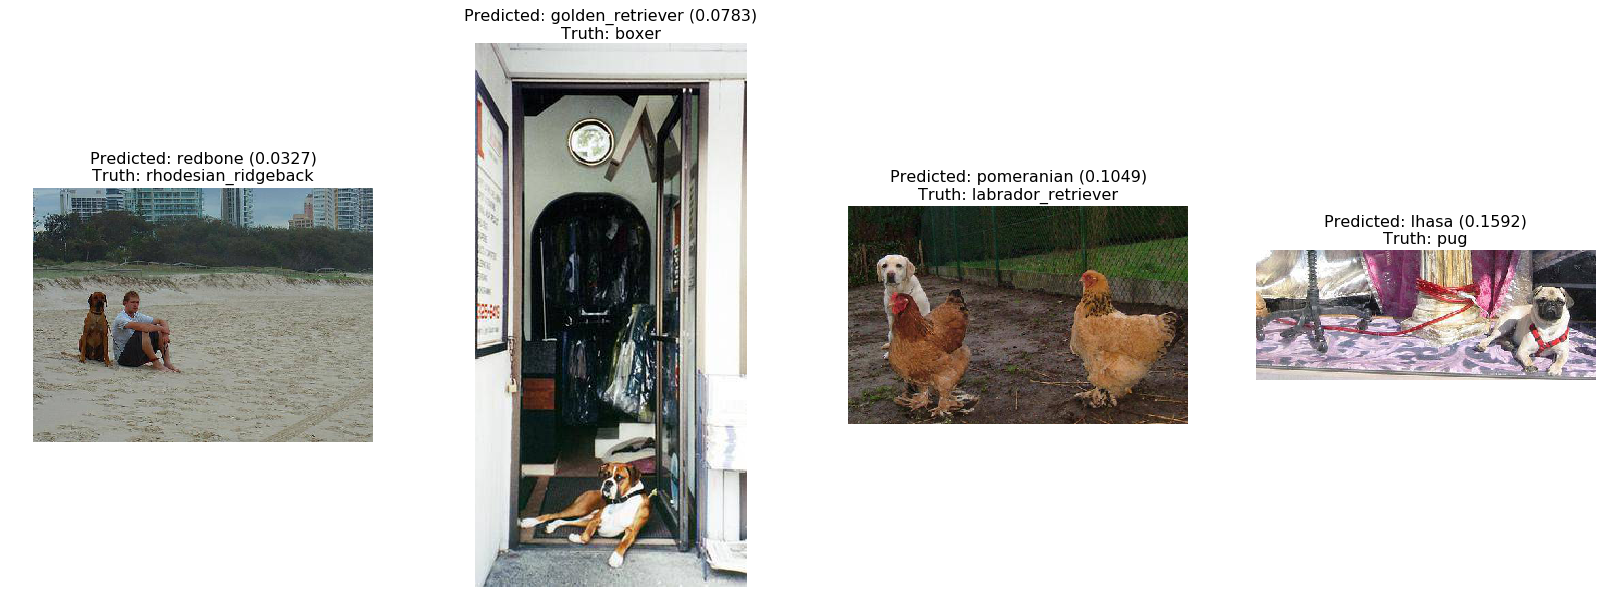

In [27]:
plot_val_with_title(most_uncertain(), "Most uncertain predictions")

### Turn off caching of frozen layers (to enable data augmentation), add SGDR (cyclic LR schedule), continue training final layer

In [28]:
lrf=learn.lr_find()

 75%|███████▌  | 96/128 [00:02<00:00, 47.79it/s, loss=0.718]


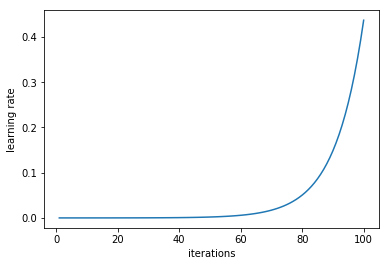

In [29]:
# look at the learning rate schedule
learn.sched.plot_lr()

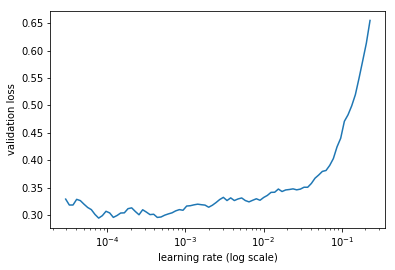

In [30]:
# pick a rate
learn.sched.plot()

In [31]:
learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[], ps=0.5)
learn.load('nas_pre')

In [32]:
%time
learn.precompute=False
learn.bn_freeze=True

learn.fit(7e-4, 3, cycle_len=1, cycle_mult=2)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs


epoch      trn_loss   val_loss   accuracy                    
    0      0.362884   0.335455   0.901663  
    1      0.364981   0.329003   0.90411                     
    2      0.342973   0.32785    0.902642                    
    3      0.334997   0.328059   0.900685                    
    4      0.328708   0.328178   0.901663                    
    5      0.315855   0.32693    0.902153                    
    6      0.325827   0.328019   0.901663                    



[array([0.32802]), 0.9016634047381332]

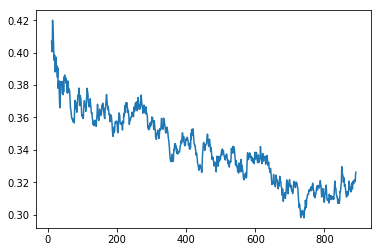

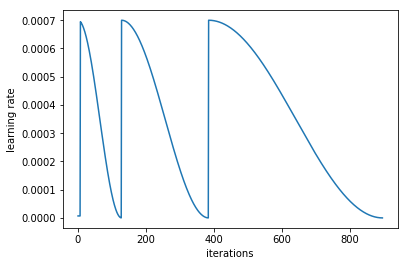

In [33]:
learn.save('nas_frozen')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

### Increase size trick

In [34]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_frozen')
learn.set_data(get_data(299))

 77%|███████▋  | 98/128 [02:31<00:46,  1.54s/it, loss=0.69] 

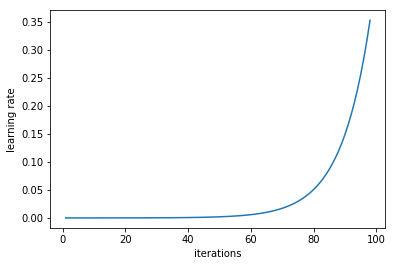

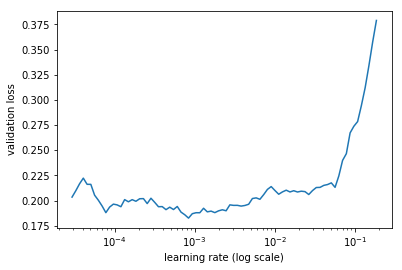

In [35]:
# recheck optimal learning rate
lrf=learn.lr_find()
learn.sched.plot_lr()
plt.show();
learn.sched.plot()
plt.show();

In [47]:
# reset lr every epoch, for 3 cycles total
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.187143   0.176464   0.945695  
    1      0.178238   0.175965   0.947652                    
    2      0.181562   0.174995   0.947162                    
    3      0.178195   0.175869   0.948141                    
    4      0.17871    0.175731   0.946673                    
    5      0.173201   0.174931   0.94863                     
    6      0.165497   0.176362   0.947162                    


[array([0.17636]), 0.947162427081054]

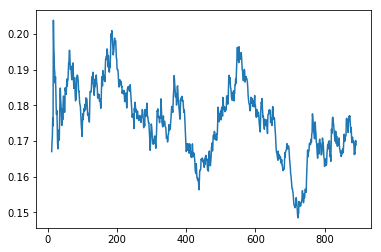

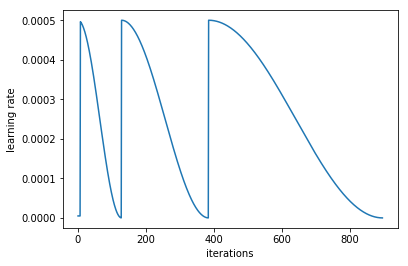

In [48]:
learn.save('nas_299')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

In [77]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_299')

In [78]:
learn.set_data(get_data(320, 40))
learn.fit(5e-5, 5, cycle_len=1, cycle_mult=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.163252   0.165832   0.949609  
    1      0.170223   0.164372   0.951566                    
    2      0.169779   0.163011   0.949609                    
    3      0.161589   0.164515   0.949119                    
    4      0.158355   0.163898   0.950098                    


[array([0.1639]), 0.9500978541234235]

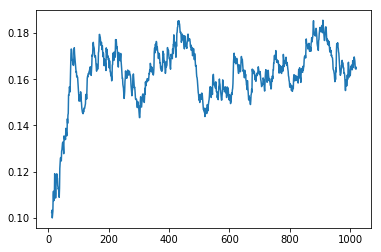

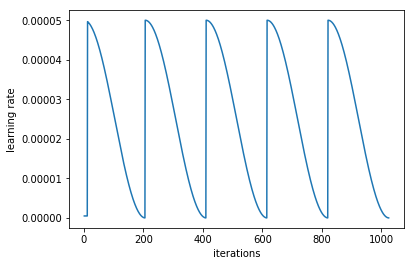

In [80]:
learn.save('nas_320')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

epoch      trn_loss   val_loss   accuracy                    
    0      0.14994    0.160675   0.954501  
    1      0.172506   0.160178   0.955479                    
    2      0.172184   0.159669   0.954501                    
    3      0.15008    0.160418   0.953523                    
    4      0.153112   0.158158   0.953523                    
    5      0.145977   0.159465   0.954501                    
    6      0.151172   0.159178   0.954501                    


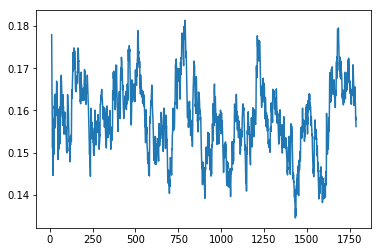

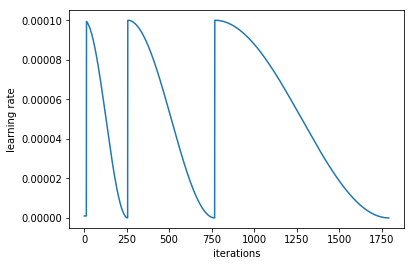

In [81]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_320')
learn.set_data(get_data(350, 32))
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)
learn.save('nas_350')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

epoch      trn_loss   val_loss   accuracy                     
    0      0.171146   0.147511   0.957926  
    1      0.195685   0.145836   0.957436                    
    2      0.178841   0.147855   0.956458                    
    3      0.173718   0.143488   0.958904                    
    4      0.196403   0.145712   0.959393                    
    5      0.151137   0.144175   0.959393                    
    6      0.156666   0.144541   0.960372                    



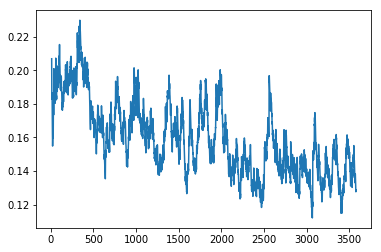

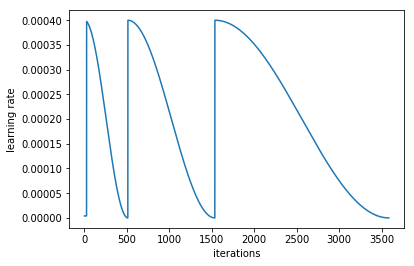

In [11]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_350')
learn.set_data(get_data(400, 16))
learn.fit(4e-4, 3, cycle_len=1, cycle_mult=2)
learn.save('nas_400')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

In [12]:
log_preds,y = learn.TTA(n_aug=9)
log_probs = log_preds
probs = np.mean(np.exp(log_probs),0)
preds = np.argmax(probs,axis=1)

accuracy_np(probs,y), metrics.log_loss(y,probs)

(0.9623287671232876, 0.12996697258395945)

epoch      trn_loss   val_loss   accuracy                    
    0      0.170027   0.145071   0.958415  
    1      0.160407   0.144487   0.958415                    
    2      0.141159   0.142949   0.960372                    
    3      0.156396   0.144694   0.959883                    
    4      0.167771   0.141673   0.959883                    
    5      0.167821   0.141449   0.959883                    
    6      0.142215   0.144602   0.960861                    


[array([0.1446]), 0.9608610568681109]

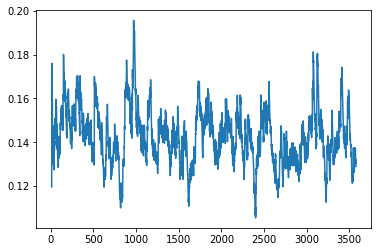

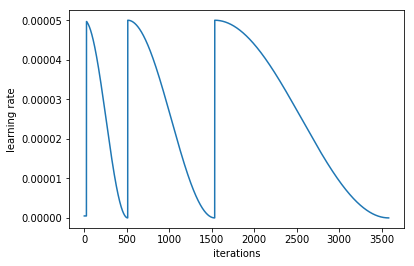

(0.9637964774951077, 0.13168073233758013)

In [13]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_400')
learn.set_data(get_data(450, 16))
learn.fit(5e-5, 3, cycle_len=1, cycle_mult=2)
learn.save('nas_450')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

log_preds,y = learn.TTA(n_aug=9)
log_probs = log_preds
probs = np.mean(np.exp(log_probs),0)
preds = np.argmax(probs,axis=1)

accuracy_np(probs,y), metrics.log_loss(y,probs)

### Fine-tune other layers using differential learning rates and learning rate cycle multipler (to slow down resets as training progresses)

Final layer is now fully trained. Other layers have already been trained to recognize imagenet photos (whereas final layers were randomly initialized), so don't want to destroy the carefully tuned weights that are already there. The earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers. First, all layers up to layer 17 will be kept frozen. Then, the next few layers will be at 1e-5, the next few at 1e-4, and our FC layers we'll leave at 1e-2 as before.

In [14]:
def freeze_to(m, n):
    c=children(m[0])
    for l in c:     set_trainable(l, False)
    for l in c[n:]: set_trainable(l, True)
        
freeze_to(learn.model, 12)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[], ps=0.5)
learn.load('nas_450')
learn.set_data(get_data(450, 16))
learn.fit([1e-5,1e-4,1e-2], 3, cycle_len=1, cycle_mult=2)

learn.save('nas_fine')
learn.sched.plot_loss()
plt.show();
learn.sched.plot_lr()
plt.show();

log_preds,y = learn.TTA(n_aug=9)
log_probs = log_preds
probs = np.mean(np.exp(log_probs),0)
preds = np.argmax(probs,axis=1)

accuracy_np(probs,y), metrics.log_loss(y,probs)

epoch      trn_loss   val_loss   accuracy                    
    0      0.268059   0.237966   0.952055  
 74%|███████▍  | 378/512 [05:54<02:05,  1.06it/s, loss=0.374]

Note: plot above is the final layers. Learning rates of earlier layers are set to fractions of the final layers rates.

### Check and analyze results on validation set using test time augmentation
Make predictions on a number of randomly augmented versions of validation set, then use the average prediction

In [ ]:
log_preds,y = learn.TTA()

In [ ]:
log_probs = log_preds
probs = np.mean(np.exp(log_probs),0)
preds = np.argmax(probs,axis=1)

accuracy_np(probs,y), metrics.log_loss(y,probs)

#cm = confusion_matrix(y, preds)
#plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [ ]:
plot_val_with_title(sort_by_correct(True), "Most correctly classified")

In [ ]:
plot_val_with_title(sort_by_correct(False), "Most incorrectly classified")

### Compare validation results to other models
### If this model is best, retrain on full training set, predict on test set, submit

check submission example, format with kaggle

try using kaggle python api


should set above up so it renames train to full_train  
then COPIES to train/valid

In [ ]:
def get_data(sz):
    stats = ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    tfms = tfms_from_stats(stats, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=[0], test_name='test', bs=64)

data = get_data(450)
learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[], ps=0.5)
learn.fit(1e-2, 5)
learn.precompute=False
learn.bn_freeze=True
learn.fit(1e-2, 5, cycle_len=1)
learn.set_data(get_data(500))
learn.fit(1e-2, 3, cycle_len=1)
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)
freeze_to(learn.model, 17)
learn.fit([1e-5,1e-4,1e-2], 3, cycle_len=1, cycle_mult=2)

In [ ]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)
preds = np.argmax(probs,axis=1)

In [ ]:
!ls {PATH}

### Retrain on all data

### Submit to Kaggle
list top results

In [2]:
sample = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))
sample.head()
sample.shape
!ls {PATH}test | wc -l

NameError: name 'pd' is not defined

In [ ]:
submission = sample.copy()
submission['label'] = preds
submission.shape
submission.head()

In [ ]:
submission.to_csv(os.path.join(PATH, 'submission.csv'), index=False)
!ls {PATH}

In [ ]:
!kaggle competitions submit -c dogs-vs-cats -f {PATH}/submission.csv -m "test"